### rackcli screenshot - h4x VCV Rack screenshot module

This h4x iterates through all the installed plugin modules and generates screenshots -- easy, huh! Ok, maybe not so easy given the need to run this h4x and Rack at the same time while simultaneously iterating through every plugin module. Lets start with a simple screenshot via [Pillow](https://github.com/python-pillow/Pillow) (PIL).

"Parsing" out the module from the screenshot is either a trial-and-error exercise, or we can use some machine learning -- lets give both a try, first brute forcing it the old-school way.

In [1]:
%run rackcli_core.ipynb


rackcli_core imports:
    hp(pixels) - convert pixels to hp
    is_running('rack') - predicate for OS-level process running, default "rack"



In [2]:
%matplotlib inline
from pprint import pprint as pp
from typing import *
from pathlib import Path
from time import sleep
from PIL import Image, ImageGrab, ImageChops
from matplotlib.pyplot import imshow 
import numpy as np
import json, mido, datetime

In [3]:
rackdir = '/Users/dirkleas/Desktop/h4x/_queue_/vcv/Rack'
catalog = json.load(open(rackdir + '/catalog.json'))
ci = json.load(open(rackdir + '/catalog.index.json'))

Here's a basic screen capture. [Here're](https://stackoverflow.com/questions/26649716/how-to-show-pil-image-in-ipython-notebook) some notes on image display in Jupyter notebook.

Here are the critical Rack fodder:

1. goal: position candidate module on 2nd row and grab some rail all around
1. on my MBP (retina display), glfwGetWindowPos(gWindow, &xpos, &ypos) returns 0,0 fullscreen, 0,22 otherwise
1. glfw gPixelRatio = 2
1. bounding box is returned as a 4-tuple defining the left, upper, right, and lower pixel coordinate
1. ex: audio module: 150x380, 2nd row, 1HP offset ==> 2*moduleWidth+2HP(30) and (moduleHeight / 380)*835

Here's some basic imaging plumbing with validation against reference crop.

In [4]:
def screenshot(filename: str, width: int, height: int, inline: bool=False) -> Image:
    'screenshot a single plugin version module on rack 2nd row, 1HP offsets, row=380px, optionally display inline'
    box = (0, 835, (2*width)+60, 835*int(height/380+1)-15) # (0, 835, 300+60, 835*2-15)
    img = ImageGrab.grab(box)
    if inline: imshow(np.asarray(img))
    img.save(filename, 'PNG')
    return(img)

def is_equivalent(image1: Image, image2: Image):
    'predicate for PIL image comparison'
    try: ImageChops.difference(image1, image2); return(True)
    except: return(False)

def reference_crop(image: Image) -> Image:
    'crop to reference size of 1HP x 1 row (0, 835, 30, 1655)'
    return(image.crop((0, 835, 30, 1655)))

# print(is_equivalent(Image.open(rackdir + '/reference.png'), Image.open(rackdir + '/installer-banner.bmp')))
# print(is_equivalent(Image.open(rackdir + '/reference.png'), Image.open(rackdir + '/reference.png')))
# print(is_equivalent(Image.open(rackdir + '/reference.png'), Image.open(rackdir + '/reference.png')))
# i = str(list(Path(rackdir + '/media').glob('*.png'))[0])
# print(is_equivalent(Image.open(rackdir + '/reference.png'), reference_crop(Image.open(i))))
# shot(f'{rackdir}/reference.png', -15, 380, True) # reference screenshot

The following plumbing assumes some type of MIDI-to-keyboard utility software (e.g. [Keyboard Maestro](https://www.keyboardmaestro.com/main/), et'al) with the following mappings (MIDI note => behavior/keystroke):

1. 69 => CTRL+SHIFT+O (Revert toolbar item hotkey)
1. 70 => set focus to Rack from Chrome (assumes it's running)
1. 71 => set focus to Chrome from Rack (assumes it's running)

This can be refactored as soon as Rack supports an extension API for "main thread" features.

In [5]:
def module_by_index_iterator(module_iter_item: List, catalog: Dict, catalog_index: Dict) -> Dict:
    'return hash-augmented module from catalog via plugin/version/module tuple by index'
    try:
        p,v,m = module_iter_item
        po = ci['plugins'][p][0]
        mo, h = ci['modules'][p + ci['sep'] + m]
        return({**catalog['plugins'][po]['models'][mo], **{'plugin': p, 'version': v, 'hash': h}})
    except: return(None)
# pp(module_by_index_iterator(ci['iterator'][6], catalog, ci))

def default_positions(modules: List, catalog: Dict, ci: Dict, col_start: int=0, row: int=0) -> List:
    'generate positions by catalog widths if available or 1HP offsets otherwise'
    if 'width' in catalog['plugins'][0]['models'][0].keys(): # use catalog width offsets
        widths = [hp(module_by_index_iterator(m, catalog, ci)['width']) for m in modules]
        positions = list(map(list, zip([sum(widths[:i])+col_start for i,w in enumerate(widths)], [row]*len(modules))))
    else: positions = list(zip(range(len(modules)), [row]*len(modules)))
    return(positions)
# pp(default_positions(ci['iterator'][0:5], catalog, ci, row=1))
# pp(default_positions(ci['iterator'][0:5], catalog, ci, col_start=1, row=1))

def module(pvm: List, pos: List) -> Dict:
    'generate subpatch module'
    plugin, version, model = pvm
    return({'plugin': plugin, 'version': version, 'model': model, 'pos': pos, 'params': [], 'data': {}})
# pp(module(ci['iterator'][0], [0,0]))

def patcher(modules: List, catalog: Dict, ci: Dict, patch_filename: str, positions: List=[], 
            col_start: int=0, row: int=0) -> Dict:
    'generate patch for specified modules of form [p,v,m] for screenshot or empty patch'
    patch = {'version': catalog['applicationVersion'], 'wires': [],
             'modules':  list(map(lambda m:module(m[0],m[1]), 
                                  list(zip(modules, default_positions(modules, catalog, ci, 
                                                                      col_start=col_start, row=row)))))}
    json.dump(patch, open(patch_filename, 'w'), indent=2, ensure_ascii=False)
    return(patch)
# pp(patcher([], catalog, ci, rackdir + '/patches/eraseme.vcv', row=1))
# pp(patcher(ci['iterator'][0:5], catalog, ci, rackdir + '/patches/eraseme.vcv', row=1))
# pp(patcher([ci['iterator'][0],], catalog, ci, rackdir + '/patches/eraseme.vcv', col_start=1, row=1))
           
def file_timestamp(path: Path) -> str:
    'generate readable string format timestamp of form YYYYMMDDHHMMSS'
    return(datetime.datetime.fromtimestamp(path.stat().st_mtime).strftime('%Y%m%d%H%M%S'))
# print(file_timestamp(Path(rackdir + '/catalog.json')))

def shotter(ms: List, c: Dict, ci: Dict, rackdir: str, patch_filename: str) -> None:
    'screenshot plugin modules with automated/midi triggering refreshes'
    print('screenshotting plugin modules to ./media, setting focus to VCV Rack now')
    not_running_msg = ' *** error, rack is not running -- possibly crashed, please investigate'
    if not is_running(): # consider starting it if not running...
        print(not_running_msg)
        return
    mido.open_output().send(mido.Message('note_on', note=70)); sleep(0.5) # head over to rack
    reference_image = screenshot(f'{rackdir}/reference.png', -15, 380, False) # 1HP reference image
    try:
        for m in ms:
            m = module_by_index_iterator(m, c, ci)
            screenshot_filename = f"{rackdir}/media/{m['hash']}.png"
            screenshot_path = Path(screenshot_filename)
            if screenshot_path.exists() and file_timestamp(Path(screenshot_filename)) >= ci['timestamp']:
                print(f"   {m['slug']}, {m['plugin']} v{m['version']} skipped, already processed")
                continue
            if not is_running():
                print(not_running_msg)
                break
            print(f" ✓ {m['slug']}, {m['plugin']} v{m['version']}")
            patcher([[m['plugin'], m['version'], m['slug']],], c, ci, patch_filename, col_start=1, row=1)
            mido.open_output().send(mido.Message('note_on', note=69)); sleep(0.25) # trigger revert/reOpen
            # invoke r4xh4x patch and capture module geometry
            img = screenshot(screenshot_filename, m['width'], m['height'])
            # compare reference to crop, delete if different and exit w/ rack crash root cause
            if not is_equivalent(reference_image, reference_crop(img)):
                Path(screenshot_filename).unlink() # delete invalid screenshot
                print(' *** error, screenshot for {} differs from reference -- rack probably crashed')
                break
            sleep(0.25)
        patcher([], c, ci, patch_filename) # finish with empty patch
        mido.open_output().send(mido.Message('note_on', note=69)); sleep(0.25) # trigger revert/reOpen
    except KeyboardInterrupt: pass
    print('all done...')
    mido.open_output().send(mido.Message('note_on', note=71)) # back to chrome

shotter(ci['iterator'][0:10], catalog, ci, rackdir, rackdir + '/patches/_r4xh4x_/_r4xh4x_.vcv')
# loot = [m for m in ci['iterator'] if m[0] in ['mscHack', 'moDllz']]
# loot = ci['iterator']
# shotter(loot, catalog, ci, rackdir, rackdir + '/patches/_h4x.vcv')

screenshotting plugin modules to ./media, setting focus to VCV Rack now
   AudioInterface, Core v0.6.1 skipped, already processed
   MIDIToCVInterface, Core v0.6.1 skipped, already processed
   QuadMIDIToCVInterface, Core v0.6.1 skipped, already processed
   MIDICCToCVInterface, Core v0.6.1 skipped, already processed
   MIDITriggerToCVInterface, Core v0.6.1 skipped, already processed
   Blank, Core v0.6.1 skipped, already processed
   Notes, Core v0.6.1 skipped, already processed
   Bogaudio-VCO, Bogaudio v0.6.7 skipped, already processed
   Bogaudio-XCO, Bogaudio v0.6.7 skipped, already processed
   Bogaudio-Additator, Bogaudio v0.6.7 skipped, already processed
all done...


Prove screenshots got generated by displaying something awesome! ;-)

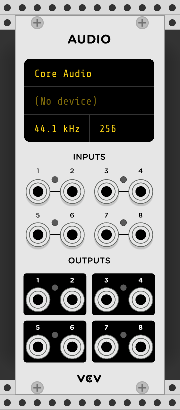

In [6]:
hash = module_by_index_iterator(ci['iterator'][0], catalog, ci)['hash']
im = Image.open(f"{rackdir}/media/{hash}.png")
im = im.resize([int(0.5 * s) for s in im.size])
im